# 🧠 Notebook complet - Approches avancées Air Paradis

Ce notebook couvre les prétraitements, embeddings, modèles Keras (dense, LSTM), BERT et Universal Sentence Encoder selon les critères CE1 à CE7.

In [1]:
# 📚 Table des matières automatique
from IPython.display import display, Markdown
display(Markdown('''
- [1. Import du jeu de données et vérification de l'équilibrage](#1.-Import-du-jeu-de-données-et-vérification-de-l'équilibrage)
- [2. Prétraitement du texte (nettoyage + stemming/lemmatisation)](#2.-Prétraitement-du-texte-(nettoyage-+-stemming/lemmatisation))
- [3.1 Baseline : TF-IDF + Régression Logistique](#3.1-Baseline-:-TF-IDF-+-Régression-Logistique)
- [3.2 Baseline : LSTM (Keras)](#3.2-Baseline-:-LSTM-(Keras))
- [4. Embeddings Word2Vec, GloVe, FastText](#4.-Embeddings-Word2Vec,-GloVe,-FastText)
  - [4.1 Chargement des embeddings GloVe et FastText](#4.1-Chargement-des-embeddings-GloVe-et-FastText)
- [5. Modèles Keras avec embeddings](#5.-Modèles-Keras-avec-embeddings)
  - [5.0 Intégration GloVe et FastText dans Keras](#5.0-Intégration-GloVe-et-FastText-dans-Keras)
  - [5.1 Modèle Keras avec Word2Vec](#5.1-Modèle-Keras-avec-Word2Vec)
  - [5.2 Modèle Keras avec GloVe](#5.2-Modèle-Keras-avec-GloVe)
  - [5.3 Modèle Keras avec FastText](#5.3-Modèle-Keras-avec-FastText)
- [6. BERT - Fine-tuning HuggingFace](#6.-BERT---Fine-tuning-HuggingFace)
- [7. Universal Sentence Encoder](#7.-Universal-Sentence-Encoder)
- [8. Synthèse comparative des modèles](#8.-Synthèse-comparative-des-modèles)
'''))



- [1. Import du jeu de données et vérification de l'équilibrage](#1.-Import-du-jeu-de-données-et-vérification-de-l'équilibrage)
- [2. Prétraitement du texte (nettoyage + stemming/lemmatisation)](#2.-Prétraitement-du-texte-(nettoyage-+-stemming/lemmatisation))
- [3.1 Baseline : TF-IDF + Régression Logistique](#3.1-Baseline-:-TF-IDF-+-Régression-Logistique)
- [3.2 Baseline : LSTM (Keras)](#3.2-Baseline-:-LSTM-(Keras))
- [4. Embeddings Word2Vec, GloVe, FastText](#4.-Embeddings-Word2Vec,-GloVe,-FastText)
  - [4.1 Chargement des embeddings GloVe et FastText](#4.1-Chargement-des-embeddings-GloVe-et-FastText)
- [5. Modèles Keras avec embeddings](#5.-Modèles-Keras-avec-embeddings)
  - [5.0 Intégration GloVe et FastText dans Keras](#5.0-Intégration-GloVe-et-FastText-dans-Keras)
  - [5.1 Modèle Keras avec Word2Vec](#5.1-Modèle-Keras-avec-Word2Vec)
  - [5.2 Modèle Keras avec GloVe](#5.2-Modèle-Keras-avec-GloVe)
  - [5.3 Modèle Keras avec FastText](#5.3-Modèle-Keras-avec-FastText)
- [6. BERT - Fine-tuning HuggingFace](#6.-BERT---Fine-tuning-HuggingFace)
- [7. Universal Sentence Encoder](#7.-Universal-Sentence-Encoder)
- [8. Synthèse comparative des modèles](#8.-Synthèse-comparative-des-modèles)


In [ ]:
import mlflow

mlflow.set_tracking_uri("http://localhost:8080")

# a copier dans le terminal : mlflow server --host 0.0.0.0 --port 8080

# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment("sentiment_analysis")

## 1. Import du jeu de données et vérification de l'équilibrage

In [2]:
# 📥 Chargement du fichier CSV d'origine
# Chargement du fichier CSV d'origine fourni (colonnes : target, id, date, flag, user, text)
import pandas as pd

input_path = 'C:/Users/sandr/OneDrive/Documents/JOB/OPENCLASSROOMS/AI_ENGINEER/Projet_7_Réalisez_une_analyse_de_sentiments_grâce_au_Deep_Learning/Workspace/'

raw_df = pd.read_csv(input_path + "data/raw/training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None)

raw_df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
raw_df['sentiment'] = raw_df['sentiment'].replace({0: 0, 4: 1})  # 0: négatif, 4: positif

# On extrait uniquement le texte et le label
df = raw_df[["text", "sentiment"]].copy()
df.head()


,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


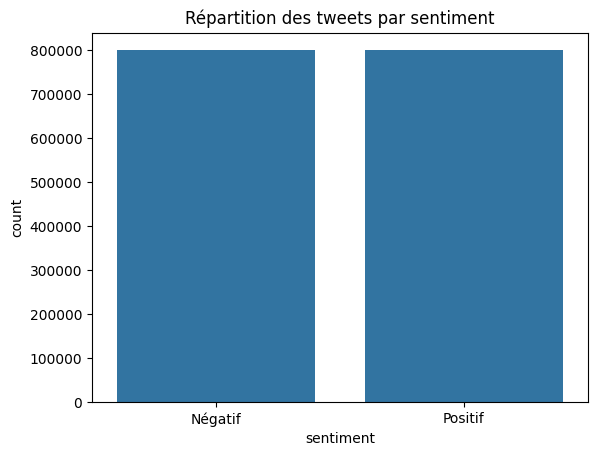

Répartition (%):
sentiment
0    50.0
1    50.0
Name: proportion, dtype: float64


In [3]:
# %pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='sentiment')
plt.title("Répartition des tweets par sentiment")
plt.xticks([0,1], ['Négatif', 'Positif'])
plt.show()

counts = df['sentiment'].value_counts(normalize=True)
print("Répartition (%):")
print(counts * 100)


## 3. Echantillonnage stratifié

In [4]:
# # 🚦 Détection RAM et définition de SAMPLE_SIZE
# import psutil
from sklearn.model_selection import train_test_split

# total_ram_gb = psutil.virtual_memory().total / 1024**3
# if total_ram_gb < 4:
#     SAMPLE_SIZE = 5000
# elif total_ram_gb < 8:
#     SAMPLE_SIZE = 10000
# elif total_ram_gb < 12:
#     SAMPLE_SIZE = 20000
# else:
#     SAMPLE_SIZE = 30000

# print(f"💡 RAM détectée : {total_ram_gb:.1f} Go - SAMPLE_SIZE sélectionné : {SAMPLE_SIZE}")

SAMPLE_SIZE = 1000  # Pour tests rapides

# 🎯 Échantillonnage stratifié unique (commune à tous les modèles)
df_sample, _ = train_test_split(
    df,
    train_size=SAMPLE_SIZE,
    stratify=df['sentiment'],
    random_state=42
)

print(f"Échantillon stratifié : {df_sample.shape[0]} tweets")


Échantillon stratifié : 1000 tweets


Vérifions l'équilibre de l'échantillon.

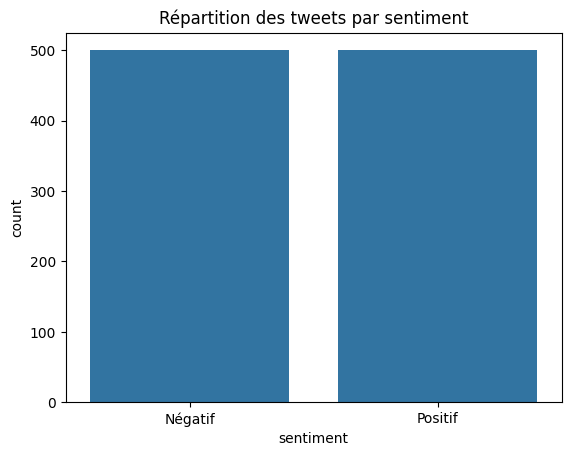

Répartition (%):
sentiment
1    50.0
0    50.0
Name: proportion, dtype: float64


In [5]:
sns.countplot(data=df_sample, x='sentiment')
plt.title("Répartition des tweets par sentiment")
plt.xticks([0,1], ['Négatif', 'Positif'])
plt.show()

counts = df_sample['sentiment'].value_counts(normalize=True)
print("Répartition (%):")
print(counts * 100)


L'échantillon est effectivement équilibré.

## 2. Prétraitement du texte (nettoyage + stemming/lemmatisation)

In [6]:
# # 🧹 Nettoyage des tweets avec stemming et lemmatisation
# # Nettoyage des tweets à partir du fichier brut
# # %pip install nltk

# import re
# import nltk
# import os
# from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.corpus import stopwords

# # 🔧 Force le chemin de recherche des ressources NLTK
# nltk_data_path = "C:/nltk_data"
# if not os.path.exists(nltk_data_path):
#     os.makedirs(nltk_data_path)

# nltk.data.path.append(nltk_data_path)

# # Ensure nltk resources are downloaded
# nltk.download('punkt', download_dir=nltk_data_path)
# nltk.download('wordnet', download_dir=nltk_data_path)
# nltk.download('omw-1.4', download_dir=nltk_data_path)
# nltk.download('stopwords', download_dir=nltk_data_path)

# # stemmer = PorterStemmer()
# # # Use the preloaded stop_words variable instead of redefining it
# # stop_words = set(stopwords.words('english'))

# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()  # ✅ AJOUT À FAIRE
# # Use the preloaded stop_words variable instead of redefining it
# stop_words = set(stopwords.words('english'))

# def clean_text(text, method='lemma'):
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text)
#     text = re.sub(r"@\w+|#", '', text)
#     text = re.sub(r"[^\w\s]", '', text.lower())
#     words = nltk.word_tokenize(text)
#     words = [w for w in words if w not in stop_words]
#     if method == 'stem':
#         return ' '.join([stemmer.stem(w) for w in words])
#     else:
#         return ' '.join([lemmatizer.lemmatize(w) for w in words])

# # Application sur le jeu de données brut
# df_sample['text_stem'] = df_sample['text'].apply(lambda x: clean_text(x, 'stem'))
# df_sample['text_lemma'] = df_sample['text'].apply(lambda x: clean_text(x, 'lemma'))


In [10]:
# Solution simplifiée pour NLTK sans dépendance aux téléchargements
import re
import pandas as pd
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Liste de stopwords simplifiée (remplace la dépendance NLTK)
STOPWORDS = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
             'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
             'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
             'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
             'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 
             'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
             'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
             'with', 'about', 'against', 'between', 'into', 'through', 'during', 
             'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 
             'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'}

# Tokenizer simplifié (remplace nltk.word_tokenize)
def simple_tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Initialisation des outils
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fonction de nettoyage sans dépendances problématiques
def clean_text(text, method='lemma'):
    # Nettoyage du texte
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text.lower())
    
    # Tokenization simplifiée
    words = simple_tokenize(text)
    
    # Filtrage des stopwords
    words = [w for w in words if w not in STOPWORDS]
    
    # Application du stemming ou lemmatisation
    if method == 'stem':
        return ' '.join([stemmer.stem(w) for w in words])
    else:
        return ' '.join([lemmatizer.lemmatize(w) for w in words])

# Test sur un exemple
print("Test sur un exemple simple:")
exemple = "This is a test tweet with #hashtags and @mentions http://example.com"
print(clean_text(exemple, 'stem'))
print(clean_text(exemple, 'lemma'))

# Fonction pour traiter le DataFrame par lots pour éviter les blocages
def process_dataframe_in_batches(df_sample, batch_size=100):
    print(f"Traitement de {len(df_sample)} tweets par lots de {batch_size}...")
    result_df = df_sample.copy()
    
    # Traiter par lots pour éviter les blocages
    for i in range(0, len(df_sample), batch_size):
        end_idx = min(i + batch_size, len(df_sample))
        print(f"Traitement du lot {i//batch_size + 1}: tweets {i+1}-{end_idx}...")
        
        batch = df_sample.iloc[i:end_idx]
        result_df.loc[batch.index, 'text_stem'] = batch['text'].apply(lambda x: clean_text(str(x), 'stem'))
        result_df.loc[batch.index, 'text_lemma'] = batch['text'].apply(lambda x: clean_text(str(x), 'lemma'))
        
    return result_df

# Appliquer au DataFrame (décommentez pour utiliser)
df_processed = process_dataframe_in_batches(df_sample, batch_size=100)
print("Terminé !")
print(df_processed[['text', 'text_stem', 'text_lemma']].head())

Test sur un exemple simple:
test tweet hashtag
test tweet hashtags
Traitement de 1000 tweets par lots de 100...
Traitement du lot 1: tweets 1-100...
Traitement du lot 2: tweets 101-200...
Traitement du lot 3: tweets 201-300...
Traitement du lot 4: tweets 301-400...
Traitement du lot 5: tweets 401-500...
Traitement du lot 6: tweets 501-600...
Traitement du lot 7: tweets 601-700...
Traitement du lot 8: tweets 701-800...
Traitement du lot 9: tweets 801-900...
Traitement du lot 10: tweets 901-1000...
Terminé !
                                                      text  \
885281                   @ZinaTrainer @Gerrigge Thank you    
1017950  For #followfriday: some newbies! @fsuwrestler2...   
959762   mmkay. so monday=johns last day end of courses...   
702896   @HOTTVampChick no  no more unless I win irvine...   
1527418  @foxandfriends  Gmornin to you guys from Chicago    

                                                 text_stem  \
885281                                               

In [11]:
# 📦 Initialisation de MLflow enrichie pour suivi des performances et efficacité
# import mlflow
import mlflow.sklearn
import time
import os

mlflow.set_experiment("air_paradis_sentiment")

def log_model_metrics(model, X_val, y_val, model_name, keras=False):
    with mlflow.start_run(run_name=model_name):
        start = time.time()
        y_pred = model.predict(X_val)
        elapsed = round((time.time() - start) / X_val.shape[0] * 1000, 3)  # ms/sample

        if y_pred.ndim > 1:
            y_pred = y_pred.ravel()
        y_pred_label = (y_pred > 0.5).astype(int)

        from sklearn.metrics import accuracy_score, f1_score, recall_score
        acc = round(accuracy_score(y_val, y_pred_label), 3)
        f1 = round(f1_score(y_val, y_pred_label), 3)
        rec = round(recall_score(y_val, y_pred_label), 3)

        mlflow.log_param("model_type", model_name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("inference_time_ms", elapsed)

        import tempfile
        if keras:
            from tensorflow.keras.models import save_model # type: ignore
            model_path = tempfile.mktemp(suffix=".h5")
            save_model(model, model_path)
        else:
            import joblib
            model_path = tempfile.mktemp(suffix=".pkl")
            joblib.dump(model, model_path)

        if os.path.exists(model_path):
            size_mb = round(os.path.getsize(model_path) / 1024 / 1024, 2)
            mlflow.log_metric("model_size_mb", size_mb)
            mlflow.log_artifact(model_path, artifact_path="models")


## 3.1 Baseline : TF-IDF + Régression Logistique

Paramétrer MLFlow pour stocker les résultats des tests  !!!

In [ ]:
# 📊 TF-IDF + Régression Logistique
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_processed['text_lemma'])

# Séparation
from sklearn.model_selection import train_test_split
X_train_vec, X_temp_vec, y_train, y_temp = train_test_split(X_tfidf, df_processed['sentiment'], test_size=0.3, stratify=df_processed['sentiment'], random_state=42)
X_val_vec, X_test_vec, y_val, y_test = train_test_split(X_temp_vec, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Entraînement
model = LogisticRegression(max_iter=200)
model.fit(X_train_vec, y_train)

# Évaluation
log_model_metrics(model, X_val_vec, y_val, "TF-IDF + LogReg", keras=False)


🏃 View run TF-IDF + LogReg at: http://localhost:8080/#/experiments/508725265954878499/runs/f555cbe867524191a5cffb64aa435b5f
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


## 3.2 Baseline : LSTM (Keras)

In [ ]:
# 📊 LSTM Baseline
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Embedding, LSTM, Dense # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

# Préparation des données
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_processed['text_lemma'])
X_seq = tokenizer.texts_to_sequences(df_processed['text_lemma'])
X_pad = pad_sequences(X_seq, maxlen=50)

X_train, X_temp, y_train, y_temp = train_test_split(X_pad, df_processed['sentiment'], test_size=0.3, stratify=df_processed['sentiment'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Modèle LSTM
model_lstm = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_length=50),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128)

# Évaluation
log_model_metrics(model_lstm, X_val, y_val, "LSTM Baseline", keras=True)





Epoch 1/3


6/6 [==============================] - 3s 123ms/step - loss: 0.6930 - accuracy: 0.5043 - val_loss: 0.6923 - val_accuracy: 0.5400
Epoch 2/3
6/6 [==============================] - 0s 46ms/step - loss: 0.6878 - accuracy: 0.6200 - val_loss: 0.6911 - val_accuracy: 0.5200
Epoch 3/3
5/5 [==============================] - 0s 7ms/step


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


🏃 View run LSTM Baseline at: http://localhost:8080/#/experiments/508725265954878499/runs/45debee75dab4b6aa6a5d08f5a2b373c
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


LSTM tout seul = Fait
LSTM + Word2Vec
LSTM + Fastext


## 4. Embeddings Word2Vec, GloVe, FastText

In [16]:
# Si X_train contient des vecteurs → il faut retourner au texte
# Exemple : on repart de la colonne text_lemma du DataFrame de base
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

X_train_idx, _, y_train, _ = train_test_split(df_processed.index, df_processed['sentiment'], test_size=0.3, stratify=df_processed['sentiment'], random_state=42)

# Exemple : extraction du texte source
X_train_text = df_processed.loc[X_train_idx, "text_lemma"]  # ou bien une version déjà séparée

sentences = [text.split() for text in X_train_text]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
w2v_model.save(input_path + "models/word2vec.model")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 4.1 Chargement des embeddings GloVe et FastText

In [17]:
# 📚 Fonction utilitaire pour charger des embeddings externes (GloVe/FastText)
import numpy as np

def load_embedding(filepath):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Chemins vers les fichiers d'embedding
glove_path = input_path + 'data/embeddings/glove.6B.100d.txt'
fasttext_path = input_path + 'data/embeddings/wiki-news-300d-1M.vec'

# Chargement
glove_embeddings = load_embedding(glove_path)
fasttext_embeddings = load_embedding(fasttext_path)

print(f"GloVe chargé : {len(glove_embeddings)} mots")
print(f"FastText chargé : {len(fasttext_embeddings)} mots")


GloVe chargé : 400000 mots
FastText chargé : 999995 mots


## 5. Modèles Keras avec embeddings

### 5.1 Modèle Keras avec Word2Vec

In [ ]:
# 🧠 Construction du modèle Keras avec couche d'embedding
# 📏 Padding des séquences textuelles à longueur fixe
# 🔢 Tokenisation des textes pour entraînement LSTM ou Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

X = df_processed['text_lemma']
y = df_processed['sentiment']

X_train_text, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val_text, X_test_text, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=50)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val_text), maxlen=50)

model_w2v = Sequential([
    Embedding(20000, 64, input_length=50),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_w2v.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=5, batch_size=128)

# Évaluation et suivi MLflow
log_model_metrics(model_w2v, X_val_pad, y_val, "Word2Vec", keras=True)


Epoch 1/5
6/6 [==============================] - 1s 34ms/step - loss: 0.6941 - accuracy: 0.4843 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
6/6 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.5171 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/5
6/6 [==============================] - 0s 11ms/step - loss: 0.6922 - accuracy: 0.5329 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.6914 - accuracy: 0.5229 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 0s 1ms/step
🏃 View run Word2Vec at: http://localhost:8080/#/experiments/508725265954878499/runs/816434297b2943a582e7ff95c2b5d4dc
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


### 5.5 LSTM + Word2Vec

In [ ]:
# 📊 Modèle LSTM avec Word2Vec
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

model_lstm_w2v = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix], input_length=X_train_pad.shape[1], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_lstm_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_w2v.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=3, batch_size=128)

# Évaluation et suivi MLflow
log_model_metrics(model_lstm_w2v, X_val_pad, y_val, "LSTM + Word2Vec", keras=True)


Epoch 1/3
6/6 [==============================] - 2s 87ms/step - loss: 0.6934 - accuracy: 0.4871 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
6/6 [==============================] - 0s 32ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5400
Epoch 3/3
5/5 [==============================] - 0s 4ms/step
🏃 View run LSTM + Word2Vec at: http://localhost:8080/#/experiments/508725265954878499/runs/23ff5ccc69ba4da892c542b132ddbc0d
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


### 5.6 LSTM + FastText

In [ ]:
# 📊 Modèle LSTM avec FastText (entraînement local)
from gensim.models import FastText
import numpy as np

# 1. Entraînement du modèle FastText sur les données d'entraînement
sentences = [text.split() for text in X_train_text]
ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4)

# 2. Création de l'embedding matrix à partir du tokenizer
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in ft_model.wv:
        embedding_matrix[i] = ft_model.wv[word]

# 3. Création du modèle LSTM avec embedding FastText
model_lstm_ft = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
              weights=[embedding_matrix], input_length=X_train_pad.shape[1], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_lstm_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_ft.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=3, batch_size=128)

# 4. Évaluation et suivi MLflow
log_model_metrics(model_lstm_ft, X_val_pad, y_val, "LSTM + FastText (local)", keras=True)


Epoch 1/3
6/6 [==============================] - 2s 82ms/step - loss: 0.6933 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
6/6 [==============================] - 0s 25ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/3
5/5 [==============================] - 0s 7ms/step
🏃 View run LSTM + FastText (local) at: http://localhost:8080/#/experiments/508725265954878499/runs/ba12da88689648428925fe88e2ac4469
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


### 5.0 Intégration GloVe et FastText dans Keras

In [23]:
# 📚 Fonction utilitaire pour charger des embeddings externes (GloVe/FastText)
import numpy as np

# Fonction pour charger des embeddings pré-entraînés
def load_embedding(filepath):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Charger GloVe
glove_path = input_path + 'data/embeddings/glove.6B.100d.txt'
glove_embeddings = load_embedding(glove_path)

# Charger FastText
fasttext_path = input_path + 'data/embeddings/wiki-news-300d-1M.vec'
fasttext_embeddings = load_embedding(fasttext_path)


In [24]:
# Créer les matrices d'embedding pour notre vocabulaire
embedding_dim_glove = 100
embedding_dim_fasttext = 300
word_index = tokenizer.word_index

embedding_matrix_glove = np.zeros((20000, embedding_dim_glove))
embedding_matrix_fasttext = np.zeros((20000, embedding_dim_fasttext))

for word, i in word_index.items():
    if i >= 20000:
        continue
    vec_g = glove_embeddings.get(word)
    if vec_g is not None:
        embedding_matrix_glove[i] = vec_g
    vec_f = fasttext_embeddings.get(word)
    if vec_f is not None:
        embedding_matrix_fasttext[i] = vec_f


### 5.2 Modèle Keras avec GloVe

In [ ]:
# 📊 Modèle Keras avec GloVe
model_glove = Sequential([
    Embedding(input_dim=embedding_matrix_glove.shape[0], output_dim=embedding_matrix_glove.shape[1],
              weights=[embedding_matrix_glove], input_length=X_pad.shape[1], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_glove.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128)

# Évaluation
log_model_metrics(model_glove, X_val, y_val, "GloVe", keras=True)


Epoch 1/3
6/6 [==============================] - 1s 78ms/step - loss: 0.6984 - accuracy: 0.5057 - val_loss: 0.6879 - val_accuracy: 0.4933
Epoch 2/3
6/6 [==============================] - 0s 21ms/step - loss: 0.6848 - accuracy: 0.5486 - val_loss: 0.6927 - val_accuracy: 0.5133
Epoch 3/3
5/5 [==============================] - 0s 4ms/step
🏃 View run GloVe at: http://localhost:8080/#/experiments/508725265954878499/runs/b6607d7de5de491cb04ad3227dfde85f
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


### 5.3 Modèle Keras avec FastText

In [ ]:
# 📊 Modèle Keras avec FastText
model_fasttext = Sequential([
    Embedding(input_dim=embedding_matrix_fasttext.shape[0], output_dim=embedding_matrix_fasttext.shape[1],
              weights=[embedding_matrix_fasttext], input_length=X_pad.shape[1], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_fasttext.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_fasttext.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128)

# Évaluation
log_model_metrics(model_fasttext, X_val, y_val, "FastText", keras=True)


Epoch 1/3
6/6 [==============================] - 2s 90ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 0.6921 - val_accuracy: 0.5533
Epoch 2/3
6/6 [==============================] - 0s 35ms/step - loss: 0.6839 - accuracy: 0.5986 - val_loss: 0.6921 - val_accuracy: 0.5200
Epoch 3/3
5/5 [==============================] - 0s 4ms/step
🏃 View run FastText at: http://localhost:8080/#/experiments/508725265954878499/runs/48b224585dfc4b1dbfcaef6ace7e058e
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


BERT avec Embedding + classification !!!

## 6. BERT - Regression Logistique

In [ ]:
# 📊 BERT + Régression Logistique (embedding)
from transformers import BertTokenizer, BertModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Chargement du tokenizer et modèle BERT (non fine-tuné)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, tokenizer, model, max_len=64):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # CLS token

# Pour accélérer la démo, on prend un échantillon réduit (ex : 5000 tweets)
# sample_df = df.sample(5000, random_state=42)
# X_bert = get_bert_embeddings(sample_df['text_lemma'].tolist(), tokenizer, bert_model)
# y_bert = sample_df['sentiment'].values

X_bert = get_bert_embeddings(df_processed['text_lemma'].tolist(), tokenizer, bert_model)
y_bert = df_processed['sentiment'].values

# Split + Modèle
X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2, stratify=y_bert, random_state=42)
model_bert = LogisticRegression(max_iter=(100)) # au lieu de 1000
model_bert.fit(X_train, y_train)
y_pred = model_bert.predict(X_test)

# Évaluation
# print("\n📌 Évaluation du modèle : BERT + LogisticRegression")
# print("----------------------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 🔍 Évaluation complète avec légèreté et performance
log_model_metrics(model_bert, X_test, y_test, "BERT + LogisticRegression", keras=False)


C:\Users\sandr\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       100
           1       0.77      0.75      0.76       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200

🏃 View run BERT + LogisticRegression at: http://localhost:8080/#/experiments/508725265954878499/runs/04280a7f0ce640f09b6afbb99c1591db
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# 📊 BERT Embedding + Dense NN Classifier
from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from sklearn.model_selection import train_test_split

# Rechargement BERT si nécessaire
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, tokenizer, model, max_len=64):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # vecteurs CLS


X_bert_embed = get_bert_embeddings(df_processed['text_lemma'].tolist(), tokenizer, bert_model)
y_bert_embed = df_processed['sentiment'].values

# Split jeu
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_bert_embed, y_bert_embed, test_size=0.2, stratify=y_bert_embed, random_state=42)

# Modèle Keras simple
model_bert_dense = Sequential([
    Dense(64, activation='relu', input_shape=(768,)),
    Dense(1, activation='sigmoid')
])
model_bert_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bert_dense.fit(X_train_b, y_train_b, validation_data=(X_val_b, y_val_b), epochs=3, batch_size=128)

# Évaluation et log MLflow
log_model_metrics(model_bert_dense, X_val_b, y_val_b, "BERT Embedding + Dense NN Classifier", keras=True)


Epoch 1/3
7/7 [==============================] - 0s 23ms/step - loss: 0.6878 - accuracy: 0.5562 - val_loss: 0.6281 - val_accuracy: 0.6800
Epoch 2/3
7/7 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6862 - val_loss: 0.5914 - val_accuracy: 0.7000
Epoch 3/3
7/7 [==============================] - 0s 1ms/step
🏃 View run BERT Embedding + Dense NN Classifier at: http://localhost:8080/#/experiments/508725265954878499/runs/5870b804ee1546e594525c404ed04e1a
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)


### 6.3 TFBertModel (Hugging Face) + Classification (Keras)

In [ ]:
# 📊 Embedding avec TFBertModel + classification Keras
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore

# Chargement du modèle et tokenizer Hugging Face
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_tf = TFBertModel.from_pretrained('bert-base-uncased')

# Préparation des entrées BERT
def get_tfbert_embeddings(texts, tokenizer, model, max_len=64):
    inputs = tokenizer(texts, padding='max_length', truncation=True,
                      return_tensors="tf", max_length=max_len)
    outputs = model(inputs)[0][:, 0, :]  # vecteur CLS
    return outputs.numpy()


X_embed = get_tfbert_embeddings(df_processed['text_lemma'].tolist(), tokenizer, bert_model_tf)
y_embed = df_processed['sentiment'].values

# Split
from sklearn.model_selection import train_test_split
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_embed, y_embed, test_size=0.2, stratify=y_embed, random_state=42)

# Modèle Keras (classification)
model_tfbert_dense = Sequential([
    Dense(64, activation='relu', input_shape=(768,)),
    Dense(1, activation='sigmoid')
])
model_tfbert_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_tfbert_dense.fit(X_train_b, y_train_b, validation_data=(X_val_b, y_val_b), epochs=3, batch_size=128)

# Évaluation et log
# eval_model_extended(model_tfbert_dense, X_val_b, y_val_b, "TFBertModel + Dense", keras=True)
log_model_metrics(model_tfbert_dense, X_val_b, y_val_b, "TFBertModel + classification Keras", keras=True)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
7/7 [==============================] - 0s 23ms/step - loss: 0.7134 - accuracy: 0.5038 - val_loss: 0.6774 - val_accuracy: 0.5400
Epoch 2/3
7/7 [==============================] - 0s 6ms/step - loss: 0.6546 - accuracy: 0.6050 - val_loss: 0.6164 - val_accuracy: 0.6850
Epoch 3/3
7/7 [==============================] - 0s 1ms/step
🏃 View run TFBertModel + classification Keras at: http://localhost:8080/#/experiments/508725265954878499/runs/31be6fb2522640b8b45535b4ba4ce05f
🧪 View experiment at: http://localhost:8080/#/experiments/508725265954878499


C:\Users\sandr\AppData\Local\Temp\ipykernel_36372\3822625902.py:34: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_path)
